In [1]:
from DataProcessing import Data

# 1. Get Data

## 1.1. Get data from folder

In [2]:
d = Data()
d.get_index_names()

S&P 500: ['AAPL', 'ORCL', 'GOOGL', 'AMZN', 'BK', 'LIFE', 'T', 'XOM']
 VN: ['VHM', 'CTR', 'FPT', 'MBB']


['AAPL',
 'ORCL',
 'GOOGL',
 'AMZN',
 'BK',
 'LIFE',
 'T',
 'XOM',
 'VHM',
 'CTR',
 'FPT',
 'MBB']

In [3]:
chosen_index = 'AAPL'
df = d.get_data(chosen_index).drop(['Date','Volume'],axis=1)

In [4]:
X = df[df.columns[0:6]].values
Y = df[df.columns[6]].values

TRAIN_PERCENT = 0.7
train_size = int(TRAIN_PERCENT*len(X))

X_train = X[0:train_size]
Y_train = Y[0:train_size]
X_test = X[train_size:len(X)]
Y_test = Y[train_size:len(Y)]

# 2. Train model

In [5]:
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [33]:
class Individual:
    def __init__(self,position = [0,0,0], velocity = [0,0,0], cognitive_coef=1, social_coef=1):
        self.cognitive_coef = cognitive_coef
        self.social_coef = social_coef
        gamma = abs(np.random.normal())
        coef0 = abs(np.random.normal())
        epsilon = abs(np.random.normal())
        self.position = [gamma,coef0,epsilon]
        self.velocity = velocity
        self.model:SVR = SVR(kernel='sigmoid',gamma=self.position[0],coef0=self.position[1],epsilon=self.position[2])
        self.best_position = position
        self.fitness = self.compute_fitness(self.model)

    def compute_fitness(self,model:SVR):
        model.fit(X_train,Y_train)
        return -mean_squared_error(Y_train,model.predict(X_train))
    
    def update_indi_best(self, new_position):
        new_model:SVR = SVR(kernel='sigmoid',gamma=new_position[0],coef0=new_position[1],epsilon=new_position[2])
        new_model_fitness = self.compute_fitness(new_model)
        if(new_model_fitness>=self.fitness):
            self.best_position = new_position
            self.model = new_model
        return self.best_position
    
    def update_velocity(self, best_pos_in_pop):
        for i in range(len(self.position)):
            r = np.random.uniform(0,1,2)
            self.velocity[i] = self.velocity[i] + self.cognitive_coef*r[0]*(self.best_position[i] - self.position[i]) + self.social_coef*r[1]*(best_pos_in_pop[i] - self.position[i])
        return self.velocity
    
    def update_position(self):
        new_pos = np.zeros(len(self.position))
        for i in range(len(self.position)):
            new_pos[i] = abs(self.velocity[i] + self.position[i])
        self.update_indi_best(new_pos)
        self.position = new_pos
        return new_pos

In [26]:
class Population:
    def __init__(self,pop_size,cognitive_coef, social_coef):
        self.pop_size = pop_size
        self.pop = []
        for i in range(pop_size):
            indi = Individual(cognitive_coef=cognitive_coef, social_coef=social_coef)
            self.pop.append(indi)
        self.cognitive_coef = cognitive_coef
        self.social_coef = social_coef

    def new_Individual(self,individual:Individual)->Individual:
        return Individual(individual.position, individual.velocity, individual.cognitive_coef, individual.social_coef)
    
    def get_best_individual(self):
        self.pop = sorted(self.pop,key=lambda x:x.fitness)
        best_individual:Individual = self.new_Individual(self.pop[-1])
        return best_individual

    def update_population(self):
        best_particle:Individual = self.get_best_individual()
        for i in range(self.pop_size):
            temp = self.new_Individual(self.pop[i])
            temp.update_velocity(best_particle.position)
            temp.update_position()
            temp.compute_fitness(temp.model)
            if(temp.fitness>self.pop[i].fitness):
                self.pop[i] = temp
            if(temp.fitness>best_particle.fitness):
                best_particle = temp
        
        return

## 2.1. Train

In [35]:
population_size = 200
cognitive_coef = 1
social_coef = 1
number_of_generation = 10

In [36]:
population = Population(population_size,cognitive_coef,social_coef)
fitness = []
moving_avg_fitness = []
EPSILON = 0.01

for i in range(number_of_generation):
    population.update_population()
    best_individual = population.get_best_individual()
    fitness.append(best_individual.fitness)
    # if(i<100):
    #     moving_avg_fitness.append(fitness[i])
    # else:
    #     moving_avg_fitness.append(np.mean(fitness[i-99:i+1]))
    #     if(abs(moving_avg_fitness[i]-moving_avg_fitness[i-1])/moving_avg_fitness[i]<EPSILON):
    #         break
    percentage = i/number_of_generation*100
    print(f'PSO: {percentage}%')
        

PSO: 0.0%
PSO: 10.0%
PSO: 20.0%
PSO: 30.0%
PSO: 40.0%
PSO: 50.0%
PSO: 60.0%
PSO: 70.0%
PSO: 80.0%
PSO: 90.0%


## 2.2. Test

In [39]:
population.get_best_individual().fitness

-1813.8857727907614

In [29]:
Y_pred = rnn_model.predict(X_test)

12/12 [==============================] - 0s 2ms/step


In [24]:
Y_pred.shape

(374, 1, 1)

In [33]:
Y_pred = Y_pred.reshape(374)

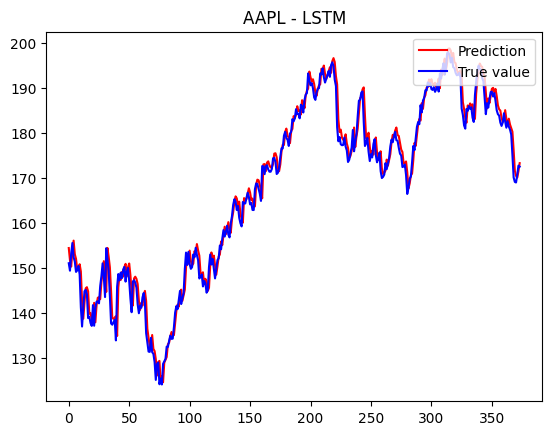

In [36]:
import matplotlib.pyplot as plt
plt.plot(Y_pred,c='red',label = 'Prediction')
plt.plot(Y_test,c='blue',label = 'True value')
plt.legend(loc='upper right')
plt.title(f'{chosen_index} - LSTM')
plt.show()